In [1]:
# By Manvydas Dapkevičius Vilnius University
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from pathlib import Path
import tkinter as tk
from tkinter import filedialog
from tkinter.filedialog import askdirectory
import csv
import os
import scipy
import sys
import glob
import scipy.integrate as integrate
# %matplotlib inline
%matplotlib widget

def displayall ():   
    root = tk.Tk()
    root.wm_attributes('-topmost', True)
    path = filedialog.askdirectory()
    root.withdraw()
    return path


In [6]:
spherecorrection = 'Edinburgh'  #    'Edinburgh'     OR     'Green'
#String to look for in files:
lookout = 'S_' # DEFAULT 'S_' use more specific string if there are too many matches
whereami = os.getcwd()
if spherecorrection == 'Edinburgh':
    spherecorr = pd.read_csv(whereami + '\\corrections\\Z_Edinburg2019Stepono.dat', delimiter='\t', index_col=None, header=0)
elif spherecorrection == 'Green':
    spherecorr = pd.read_csv(whereami + '\\corrections\\Z_Green2019.dat', delimiter='\t', index_col=None, header=0)
else:
    print('Invalid sphere correction')
spherecorr.columns = ['WL', 'corr']
path = displayall()
used = set()
df = pd.DataFrame()
names = os.listdir(path)
namesspectra = [x for x in names if lookout in x and '.txp' in x]  

print(namesspectra)
print('Total measurements loaded:', len(namesspectra))


['S_PPO1E-2M_Ir-C1E-4M_exp40ms_avg100x_@450nm_focused.txp']
Total measurements loaded: 1


S_PPO1E-2M_Ir-C1E-4M_exp40ms_avg100x_@450nm_focused.txp


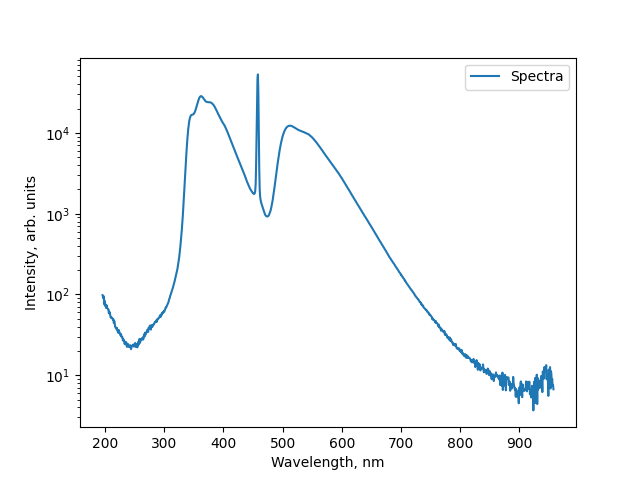

In [3]:
f = 0
print(namesspectra[f])
plt.close()
df['WL'] = pd.read_csv(path + '\\' +
                       namesspectra[f], usecols=['@0'], sep='\t')
df['S'] = pd.read_csv(path + '\\' +
                      namesspectra[f], usecols=['0.000000'], sep='\t')
plt.plot(df['WL'], df['S'], label='Spectra')
plt.xlabel('Wavelength, nm'); plt.ylabel('Intensity, arb. units')
plt.yscale('log')
plt.legend()
plt.show()


A_PPO1E-2M_Ir-C1E-4M_exp30ms_avg100x_@450nm_focused.txp
B_PPO1E-2M_Ir-C1E-4M_exp30ms_avg100x_@450nm_focused.txp
C_PPO1E-2M_Ir-C1E-4M_exp30ms_avg100x_@450nm_focused.txp
Sample  S_PPO1E-2M_Ir-C1E-4M_exp40ms_avg100x_@450nm_focused.txp  absorbed  35.4  and has a QY of  3.1  with corr  3.24 QY with Pb 3.05  with corr 3.2


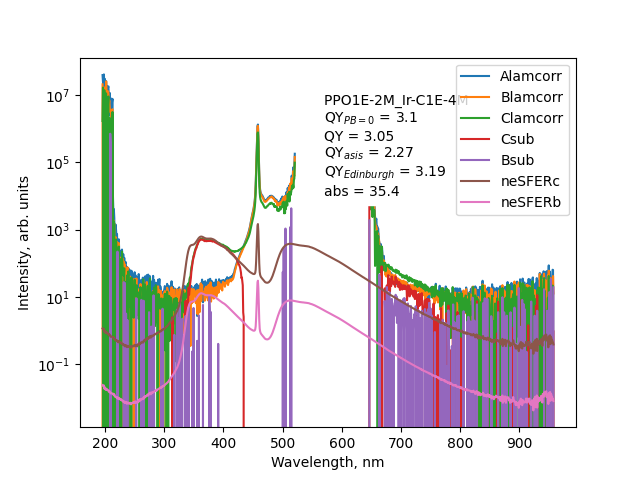

In [13]:
# This cell proccesses data and calculates QY
filter = 'PC11_5mm' # example 'CC8' leave empty for no filter C3C8_3mm
f = 0 # sample number
measurement = 'C' # Default 'C', use this to cycle between C measurements 'C1, C2;' etc.
comment = '' + measurement
integrate_from_spectra = 300 #350
integrate_to_spectra = 445 #520
integrate_from_laser = 445 #525 
integrate_to_laser = 466 #540

coff = 0.012
coff2 = 1

abscorr = 1.6

df = pd.DataFrame()
if filter:
    filtercorr = pd.read_csv(whereami + '\\filters\\' + filter + ".txt", delimiter='\t', index_col=None, header=None)
    filtercorr.columns = ['WL', 'corr']
    df['corr'] = filtercorr['corr'] / spherecorr['corr']
else:
    df['corr'] = 1 / spherecorr['corr']

namecrop = lookout.replace('S_', 'B_') + namesspectra[f].split('_e')[0].split(lookout)[1]    
# namecrop = "B_" + namesspectra[f].split('_')[1] + "_" + namesspectra[f].split('_')[2]# + "_" + namesspectra[f].split('_')[3] + "_" + namesspectra[f].split('_')[4]
namessph = [x for x in names if namecrop in x]
namessph = namessph[0]

df['WL'] = pd.read_csv(path + '\\' +
                       namesspectra[f], usecols=['@0'], sep='\t')
df['S'] = pd.read_csv(path + '\\' +
                      namesspectra[f], usecols=['0.000000'], sep='\t')
df['A'] = pd.read_csv(path + '\\' +
                      namessph.replace('B_', 'A_'), usecols=['0.000000'], sep='\t')
df['B'] = pd.read_csv(path + '\\' + namessph,
                      usecols=['0.000000'], sep='\t')
df['C'] = pd.read_csv(path + '\\' + namessph.replace('B_', measurement + '_'), usecols=['0.000000'], sep='\t')
df['Alamcorr'] = df['A'] * df['WL'] / df['corr'] / 200
df['Blamcorr'] = df['B'] * df['WL'] / df['corr'] / 200
df['Clamcorr'] = df['C'] * df['WL'] / df['corr'] / 200
df['Csub'] = df['Clamcorr'] - df['Alamcorr']
df['Bsub'] = df['Blamcorr'] - df['Alamcorr']
df['neSFERc'] = df['S'] * df['WL'] * coff / 200


dfS = df.copy()
dfS = dfS[dfS['WL'] < integrate_to_spectra]
dfS = dfS[dfS['WL'] > integrate_from_spectra]
c = max(dfS['Csub']) / max(dfS['Bsub'])
df['neSFERb'] = (df['S'] * df['WL'] * coff / 200) / c * coff2
dfS = df.copy()
dfS = dfS[dfS['WL'] < integrate_to_spectra]
dfS = dfS[dfS['WL'] > integrate_from_spectra]
Pc = float(np.trapz(dfS['neSFERc'], x=dfS['WL']))
Pb = float(np.trapz(dfS['neSFERb'], x=dfS['WL']))

Pcasis = float(np.trapz(dfS['Csub'], x=dfS['WL']))
Pbasis = float(np.trapz(dfS['Bsub'], x=dfS['WL']))

plt.close()
plt.yscale('log')
plt.plot(df['WL'], df['Alamcorr'], label='Alamcorr')
plt.plot(df['WL'], df['Blamcorr'], label='Blamcorr')
plt.plot(df['WL'], df['Clamcorr'], label='Clamcorr')
plt.plot(df['WL'], df['Csub'], label='Csub')
plt.plot(df['WL'], df['Bsub'], label='Bsub')
plt.plot(df['WL'], df['neSFERc'], label='neSFERc')
plt.plot(df['WL'], df['neSFERb'], label='neSFERb')
# plt.xlim(integrate_from_spectra, integrate_to_spectra)
# plt.ylim(1E1, 1E5)


dfL = df.copy()
dfL = dfL[dfL['WL'] < integrate_to_laser]
dfL = dfL[dfL['WL'] > integrate_from_laser]
Lc = float(np.trapz(dfL['Clamcorr'], x=dfL['WL']))
Lb = float(np.trapz(dfL['Blamcorr'], x=dfL['WL']))
La = float(np.trapz(dfL['Alamcorr'], x=dfL['WL']))
abs = round(1 - (Lc/Lb), 3)
qy = round(100*(Pc/(La*(abs))), 2)
qy2 = round(100*(Pc/(La*(abs-abscorr/100))), 2)
qy3 = round(100*((Pc-(1-abs)*Pb)/(La*abs)), 2)
qy4 = round(100*((Pc-(1-(abs-abscorr/100))*Pb)/(La*(abs-abscorr/100))), 2)

qyasis = round(100*((Pcasis-(1-abs)*Pbasis)/(La*abs)), 2)
reabs = 1 - (Pcasis/Pc)
qy_ed = round((qyasis/(1-reabs+(reabs*qyasis/100))), 2)

print(namessph.replace('B_', 'A_'))
print(namessph)
print(namessph.replace('B_', 'C_').replace(
    'C_' + namesspectra[f].split('_')[1], str(measurement) + '_' + namesspectra[f].split('_')[1]))

print('Sample ', namesspectra[f], ' absorbed ', round(
    abs*100, 2), ' and has a QY of ', qy, ' with corr ', qy2, 'QY with Pb', qy3, ' with corr', qy4)
message = '%s  \nQY$_{PB=0}$ = %s \nQY = %s \nQY$_{as is}$ = %s \nQY$_{Edinburgh}$ = %s \nabs = %s'%(namesspectra[f].split('_')[1] + '_' + namesspectra[f].split('_')[2].replace('.txp',''), qy, qy3, qyasis, qy_ed, round(abs*100, 2))
plt.xlabel('Wavelength, nm'); plt.ylabel('Intensity, arb. units')
plt.text(570, 1E4, message, fontsize = 10 , backgroundcolor = 'w')
plt.legend()
plt.show()


# THIS SECTION WRITES USER PARAMETERS FILE
now = datetime.datetime.now()
now = now.strftime("%Y/%m/%d %H:%M:%S")
headerList = ['Time', 'Sample', 'comment', 'La', 'Lb', 'Lc', 'Pc', 'Pb', 'abs', 'abscorr', 'qy Pb=0 no abscorr',
              'qy Pb=0 with abscorr', 'qy no abscorr', 'qy with abscorr', 'qy as is', 'qy Edinburgh','P integrate from', 'P integrate to', 'L integrate from', 'Pc integrate to', 'filter']
parameters_list = [now, namesspectra[f], comment, La, Lb, Lc, Pc, Pb, round(
    abs*100, 2), abscorr, qy, qy2, qy3, qy4, qyasis, qy_ed, integrate_from_spectra, integrate_to_spectra, integrate_from_laser, integrate_to_laser, filter]
csvname = os.path.join(path + "\\" + 'QY.csv')
if not os.path.exists(csvname):
    with open(csvname, 'a', newline='') as csvfile:
        resultwriter = csv.writer(csvfile, delimiter=';')
        resultwriter.writerow(headerList)
    with open(csvname, 'a', newline='') as csvfile:
        resultwriter = csv.writer(csvfile, delimiter=';')
        resultwriter.writerow(parameters_list)
else:
    with open(csvname, 'a', newline='') as csvfile:
        resultwriter = csv.writer(csvfile, delimiter=';')
        resultwriter.writerow(parameters_list)
    # print(df)

    # df = pd.read_csv(pathfullspectra + '\\' + f + namerest, usecols = ['0.000000'], sep='\t')


In [73]:
# This cell exports the dataset used for QY calc above

csvdatname = os.path.join(path + "\\" + namesspectra[f].split('_')[1] + "_" + measurement + "_" + 'spectraldata.csv')
df.replace([np.inf, -np.inf], 0, inplace=True)
df.to_csv(csvdatname)